# WHI Analysis Scripts

In [3]:
import pandas as pd 
import numpy as np
from scipy.stats import norm
import sys 

sys.path.append('../data/')
sys.path.append('../models/')
from falsifier import Falsifier
from baselines import MetaAnalyzer, EvolvedMetaAnalyzer, SimpleBaseline
from estimator import CATE
from whi.DataModuleWHI import DataModuleWHI

/opt/conda/zeshanmh/envs/p3z/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
# plt.rcParams['text.usetex'] = True
# plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

In [3]:
sel1 = pd.read_csv('~/research/rct_obs_causal/experiments/whi_results/sel1_final.csv')
sel3 = pd.read_csv('~/research/rct_obs_causal/experiments/whi_results/sel3_final.csv')
conf1 = pd.read_csv('~/research/rct_obs_causal/experiments/whi_results/conf1.csv')
conf3 = pd.read_csv('~/research/rct_obs_causal/experiments/whi_results/conf3.csv')
print(conf1['accept'])
print(conf1.columns)
cur = conf3  

0    0
1    0
2    0
3    0
Name: accept, dtype: int64
Index(['Unnamed: 0', 'strata_num', 'strata_name', 'lci_out_rct', 'uci_out_rct',
       'lci_out_aos', 'uci_out_aos', 'lci_out_meta', 'uci_out_meta',
       'lci_out_evo', 'uci_out_evo', 'lci_out_simple', 'uci_out_simple',
       'accept', 'obs_0_estimate', 'obs_0_sd', 'obs_1_estimate', 'obs_1_sd',
       'obs_2_estimate', 'obs_2_sd', 'obs_3_estimate', 'obs_3_sd',
       'obs_4_estimate', 'obs_4_sd'],
      dtype='object')


In [13]:
strata_metadata = [
            ('pregnant, alcohol',True), # (group name, whether or not strata is supported on RCT)
            ('pregnant, no alcohol',True),
            ('not pregnant, alcohol',False),
            ('not pregnant, no alcohol',False)
    ]
lci_out_rct = cur['lci_out_rct'].values; uci_out_rct = cur['uci_out_rct'].values
lci_out_gate = cur['lci_out_aos'].values; uci_out_gate = cur['uci_out_aos'].values
lci_out_meta = cur['lci_out_meta'].values; uci_out_meta = cur['uci_out_meta'].values
lci_out_evo = cur['lci_out_evo'].values; uci_out_evo = cur['uci_out_evo'].values
lci_out_simple = cur['lci_out_simple'].values; uci_out_simple = cur['uci_out_simple'].values

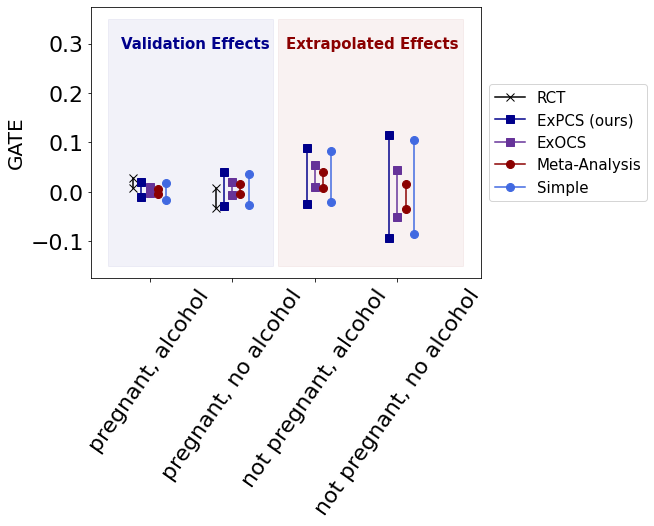

In [14]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
positions = []; labels = []
for d,strata in enumerate(strata_metadata): 
    name = strata[0]
    in_rct = strata[1]
    if d != 0: 
        label1, label2, label3, label4, label5, label6 = None, None, None, None, None, None
    else: 
        label1, label2, label3, label4, label5, label6 = 'ExPCS (ours)', 'RCT', 'Meta-Analysis','ExOCS', 'Simple', 'True GATE'
    if in_rct: 
        ax.plot((d-0.2,d-0.2),(lci_out_rct[d],uci_out_rct[d]), marker='x', ms=8, color='black', label=label2)
    ax.plot((d-0.1,d-0.1),(lci_out_gate[d],uci_out_gate[d]), marker='s', ms=8, color='darkblue', label=label1) # ours
    ax.plot((d,d),(lci_out_evo[d],uci_out_evo[d]), marker='s', ms=8, color='rebeccapurple', label=label4)
    ax.plot((d+0.1,d+0.1),(lci_out_meta[d],uci_out_meta[d]), marker='o', ms=8, color='darkred', label=label3)
    ax.plot((d+0.2,d+0.2),(lci_out_simple[d],uci_out_simple[d]), marker='o', ms=8, color='royalblue', label=label5)
    # ax.plot((d-0.4,d+0.4),(true_cates[d],true_cates[d]),linestyle='--',color='red',label=label6)
    positions.append(d)
    labels.append(name)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim() 
ax.fill_between([-.5,1.5],-0.15,0.35,alpha=0.05,color='darkblue')
ax.fill_between([1.55,3.8],-0.15,0.35,alpha=0.05,color='darkred')
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylabel('GATE',fontsize=20)
legend_properties = {'weight':'bold'}
for item in ax.get_xticklabels():
    item.set_rotation(55)
# ax.legend(fontsize=14,loc='lower left',ncol=2)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
t = ax.text(
    .55, .3, "Validation Effects", ha="center", va="center", size=15, color='darkblue', fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.32", fc="None", alpha=0., ec="darkblue", lw=2))
t = ax.text(
    2.7, .3, "Extrapolated Effects", ha="center", va="center", size=15, color='darkred', fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.32", fc="None", alpha=0., ec="darkred", lw=2))
fig.savefig('./plots/whi_conf3.pdf',bbox_inches='tight')

## Experiment 2 Analysis

In [5]:
def get_results(lower_m, upper_m, lower_rct, upper_rct): 
    ''' 
        Alternate definitions of coverage: 
            coverage = int((lower_m <= lower_rct) & (upper_m >= upper_rct))
            coverage = 1-int((upper_m < lower_rct) | (lower_m > upper_rct))
    ''' 
    point_estimate = (upper_rct - lower_rct) / 2. 
    coverage = int((point_estimate >= lower_m) & (point_estimate <= upper_m))
    if lower_rct > 0: 
        class_rct = 1
    elif upper_rct < 0: 
        class_rct = -1 
    else: 
        class_rct = 0 
    if lower_m > 0: 
        class_m = 1
    elif upper_m < 0: 
        class_m = -1 
    else: 
        class_m = 0

    length   = upper_m - lower_m 
    reject_m = int((0 < lower_m) | (0 > upper_m))
    reject_rct = int((0 < lower_rct) | (0 > upper_rct))
    return coverage, length, reject_m, reject_rct, class_rct, class_m


In [6]:
path = '/home/zeshanmh/research/rct_obs_causal/experiments/whi_results/exp2_runs/sel_bias_exp2_groupexpansion_nohp_obsfix_TEST_woracle.csv'
df = pd.read_csv(path)

validation = []
for k in range(0,df.shape[0],4): 
    validation.append(k)
    validation.append(k+1)

results = []
for i in range(0,df.shape[0]): 
    print(df.iloc[i])
    if not np.isnan(df.iloc[i]['uci_out_aos']): 
        result_add = {}
        lower_rct = df.iloc[i]['lci_out_rct']
        upper_rct = df.iloc[i]['uci_out_rct']

        g = 'extrapolation'
        if i in validation: 
            g = 'validation'
        
        names = ['gate', 'oracle', 'meta', 'simple', 'exocs']
        cols  = ['aos', 'oracle', 'meta', 'simple', 'evo']
        
        for j in range(len(names)): 
            lower_m = df.iloc[i][f'lci_out_{cols[j]}']
            upper_m = df.iloc[i][f'uci_out_{cols[j]}']
            coverage, length, reject_m, reject_rct, class_rct, class_m = get_results(lower_m, upper_m, lower_rct, upper_rct)
            accepted_obs = [int(x) for x in df.iloc[i]['accept'].split(',')]
            include_unbiased = int(0 in accepted_obs)
            include_unbiased_exactly = int((0 in accepted_obs) & (len(accepted_obs) <= 2))
            result_add = {
                'name': df.iloc[i]['strata_name'],
                'group_type': g, 
                'method': names[j], 
                'coverage': coverage, 
                'length': length, 
                'include_unbiased': include_unbiased, 
                'include_unbiased_exactly': include_unbiased_exactly, 
                'reject_method': reject_m, 
                'reject_rct': reject_rct, 
                'class_rct': class_rct, 
                'class_m': class_m, 
                'point_estimate': (upper_rct - lower_rct) / 2, 
                'lower_m': lower_m, 
                'upper_m': upper_m
            }
            results.append(result_add)


R = pd.DataFrame(results)


Unnamed: 0                                   0
strata_name       ALCNOW_Yes == 1, BMI >= 30.0
lci_out_rct                             -0.014
uci_out_rct                            0.07135
lci_out_aos                          -0.053931
uci_out_aos                           0.032187
lci_out_meta                         -0.292051
uci_out_meta                         -0.006412
lci_out_evo                          -0.050683
uci_out_evo                           0.023833
lci_out_simple                       -0.423819
uci_out_simple                        0.028912
lci_out_oracle                       -0.019977
uci_out_oracle                        0.032187
accept                                     0,1
obs_0_estimate                        0.006105
obs_0_sd                              0.011636
obs_1_estimate                       -0.031928
obs_1_sd                              0.009817
obs_2_estimate                       -0.090013
obs_2_sd                              0.010454
obs_3_estimat

In [7]:
R['match_fp'] = ((R['reject_method'] == 1) & (R['reject_rct'] == 0)).astype(int)
R['match_fn'] = ((R['reject_method'] == 0) & (R['reject_rct'] == 1)).astype(int)
R['match_tp'] = ((R['reject_method'] == 1) & (R['reject_rct'] == 1)).astype(int)
R['match_tn'] = ((R['reject_method'] == 0) & (R['reject_rct'] == 0)).astype(int)
R[R['method'] == 'gate']

,name,group_type,method,coverage,length,include_unbiased,include_unbiased_exactly,reject_method,reject_rct,class_rct,class_m,point_estimate,lower_m,upper_m,match_fp,match_fn,match_tp,match_tn
0,"ALCNOW_Yes == 1, BMI >= 30.0",validation,gate,0,0.086117,1,1,0,0,0,0,0.042675,-0.053931,0.032187,0,0,0,1
5,"ALCNOW_Yes == 1, BMI < 30.0",validation,gate,0,0.046607,1,1,0,1,1,0,0.025607,-0.030889,0.015719,0,1,0,0
10,"ALCNOW_Yes == 0, BMI >= 30.0",extrapolation,gate,1,0.186328,1,1,0,0,0,0,0.082168,-0.062217,0.124111,0,0,0,1
15,"ALCNOW_Yes == 0, BMI < 30.0",extrapolation,gate,1,0.109880,1,1,0,0,0,0,0.066521,-0.033603,0.076277,0,0,0,1
20,"ALCNOW_Yes == 1, BLACK_Yes == 1",validation,gate,0,0.050664,1,1,1,0,0,-1,0.089260,-0.056475,-0.005811,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10035,"PLATELET < 244.0, HEMATOCR < 40.0",extrapolation,gate,0,0.059315,1,1,0,0,0,0,0.043174,-0.045901,0.013414,0,0,0,1
10040,"WBC >= 6.0, HEMATOCR >= 40.0",validation,gate,1,0.069035,1,1,1,1,1,1,0.044224,0.001284,0.070319,0,0,1,0
10045,"WBC >= 6.0, HEMATOCR < 40.0",validation,gate,0,0.110259,1,1,1,0,0,-1,0.059223,-0.111171,-0.000912,1,0,0,0
10050,"WBC < 6.0, HEMATOCR >= 40.0",extrapolation,gate,1,0.086358,1,1,0,0,0,0,0.035440,-0.043063,0.043295,0,0,0,1


In [12]:
sub    = R[(R['method'] == 'gate') | (R['method'] == 'simple')]
gate   = sub[sub['method'] == 'gate']
simple = sub[sub['method'] == 'simple']
d = pd.merge(gate, simple, on='name')
mismatch = d[(d['coverage_x'] == 1) & (d['coverage_y'] == 0)]
mismatch_subset = mismatch[['name', 'group_type_x', 'method_x', 'method_y', 'coverage_x', 'coverage_y', 'point_estimate_x', 'lower_m_x', 'upper_m_x', 'lower_m_y', 'upper_m_y', 'include_unbiased_exactly_x']]
display(mismatch_subset[:50])

,name,group_type_x,method_x,method_y,coverage_x,coverage_y,point_estimate_x,lower_m_x,upper_m_x,lower_m_y,upper_m_y,include_unbiased_exactly_x
24,"ALCNOW_Yes == 1, LIVPRT_No == 1",validation,gate,simple,1,0,0.043991,-0.014846,0.044433,-0.388392,0.040711,1
27,"ALCNOW_Yes == 0, LIVPRT_No == 0",extrapolation,gate,simple,1,0,0.060990,-0.032405,0.063099,-0.385153,0.060847,1
37,"ALCNOW_Yes == 1, AGE < 60.0",validation,gate,simple,1,0,0.033102,-0.017112,0.033926,-0.339898,0.030722,1
50,"ALCNOW_Yes == 0, LSTPAPDY >= -759.0",extrapolation,gate,simple,1,0,0.069571,-0.024950,0.071246,-0.389334,0.065207,1
79,"ALCNOW_Yes == 0, MEDICARE_Yes == 0",extrapolation,gate,simple,1,0,0.057095,-0.030461,0.061700,-0.352242,0.055914,1
124,"BMI >= 30.0, BKBONE_Yes == 1",validation,gate,simple,1,0,0.065696,-0.038074,0.067864,-0.461766,0.061213,1
138,"BMI < 30.0, AGE >= 60.0",extrapolation,gate,simple,1,0,0.030412,-0.020784,0.031519,-0.362646,0.028707,1
153,"BMI >= 30.0, LSTPAPDY < -759.0",validation,gate,simple,1,0,0.055475,-0.017649,0.058212,-0.458538,0.053449,1
158,"BMI < 30.0, TMINWK >= 191.0",extrapolation,gate,simple,1,0,0.034431,-0.017751,0.035245,-0.323682,0.032979,1
163,"BMI < 30.0, HEIGHT < 161.0",extrapolation,gate,simple,1,0,0.037021,-0.016516,0.037483,-0.339992,0.034181,1


In [7]:
methods = ['gate', 'oracle', 'exocs', 'meta', 'simple']

for method in methods: 
    
    cov = R[(R['method']==method) & (R['group_type'] == 'extrapolation')]['coverage'].mean()
    length = R[(R['method']==method) & (R['group_type'] == 'extrapolation')]['length'].mean()
    # match = R[(R['method']==method) & (R['group_type'] == 'extrapolation')]['match_rct'].mean()
    include_unbiased_rate = R[(R['method'] == method) & (R['group_type'] == 'extrapolation')]['include_unbiased'].mean()
    include_unbiased_exactly_rate = R[(R['method'] == method) & (R['group_type'] == 'extrapolation')]['include_unbiased_exactly'].mean()
    match_fp = R[(R['method']==method) & (R['group_type'] == 'extrapolation')]['match_fp'].sum()
    match_fn = R[(R['method']==method) & (R['group_type'] == 'extrapolation')]['match_fn'].sum()
    match_tp = R[(R['method']==method) & (R['group_type'] == 'extrapolation')]['match_tp'].sum()
    match_tn = R[(R['method']==method) & (R['group_type'] == 'extrapolation')]['match_tn'].sum()
    if method == 'gate': 
        print(f'{method} metrics -- coverage: {cov}, length: {length}, include_unbiased: {include_unbiased_rate}, include_unbiased_exactly_rate: {include_unbiased_exactly_rate}, match_fp: {match_fp}, match_fn: {match_fn}, match_tp: {match_tp}, match_tn: {match_tn}')
    else: 
        print(f'{method} metrics -- coverage: {cov}, length: {length}, match_fp: {match_fp}, match_fn: {match_fn}, match_tp: {match_tp}, match_tn: {match_tn}')

    # cov = R[(R['method']==method)]['coverage'].mean()
    # length = R[(R['method']==method)]['length'].mean()
    # include_unbiased_rate = R[(R['method'] == method) & (R['group_type'] == 'extrapolation')]['include_unbiased'].mean()
    # include_unbiased_exactly_rate = R[(R['method'] == method) & (R['group_type'] == 'extrapolation')]['include_unbiased_exactly'].mean()
    # match_fp = R[(R['method']==method)]['match_fp'].sum()
    # match_fn = R[(R['method']==method)]['match_fn'].sum()
    # match_tp = R[(R['method']==method)]['match_tp'].sum()
    # match_tn = R[(R['method']==method)]['match_tn'].sum()
    # print(f'{method} metrics -- coverage: {cov}, length: {length}, match_fp: {match_fp}, match_fn: {match_fn}, match_tp: {match_tp}, match_tn: {match_tn}')
    # print('')


gate metrics -- coverage: 0.4552683896620278, length: 0.07942789755452069, include_unbiased: 0.9920477137176938, include_unbiased_exactly_rate: 0.9920477137176938, match_fp: 62, match_fn: 103, match_tp: 5, match_tn: 836
oracle metrics -- coverage: 0.44433399602385687, length: 0.06752599627090049, match_fp: 103, match_fn: 100, match_tp: 8, match_tn: 795
exocs metrics -- coverage: 0.2654075546719682, length: 0.056391552606189756, match_fp: 196, match_fn: 100, match_tp: 8, match_tn: 702
meta metrics -- coverage: 0.05864811133200795, length: 0.2672258519610241, match_fp: 330, match_fn: 60, match_tp: 48, match_tn: 568
simple metrics -- coverage: 0.3986083499005964, length: 0.41560103252637987, match_fp: 25, match_fn: 108, match_tp: 0, match_tn: 873


In [41]:
df.columns.values

array(['Unnamed: 0', 'strata_name', 'lci_out_rct', 'uci_out_rct',
       'lci_out_aos', 'uci_out_aos', 'lci_out_meta', 'uci_out_meta',
       'lci_out_evo', 'uci_out_evo', 'lci_out_simple', 'uci_out_simple',
       'accept', 'obs_0_estimate', 'obs_0_sd', 'obs_1_estimate',
       'obs_1_sd', 'obs_2_estimate', 'obs_2_sd', 'obs_3_estimate',
       'obs_3_sd', 'obs_4_estimate', 'obs_4_sd'], dtype=object)

In [3]:
import os 
path = '/home/zeshanmh/research/rct_obs_causal/experiments/whi_results/unbiased_runs_half/'
gate_files = os.listdir(path)
gate_files = [os.path.join(path, x) for x in gate_files if 'GATE' in x]

num_reject_total = []
num_reject_below_threshold = 0.
from collections import defaultdict

feat_to_reject = defaultdict(int)
for f in gate_files: 
    df = pd.read_csv(f)
    num_reject_per = 0.
    total_cov = 0
    for i in df.iterrows(): 
        if i[1]['strata_name'] == 'PREG_Yes': 
            continue
        if i[0]/2 % 2 == 0 and np.isnan(i[1]['accept']): 
            print(i)
            print(f"{i[1]['strata_name']}")
            feat_to_reject[i[1]['strata_name']] += 1
            num_reject_per += 1
        
    # print(f'for file {f}, num_reject average: {num_reject_per / 32}')
    if (num_reject_per / 31) < 0.05: 
        num_reject_below_threshold += 1
    num_reject_total.append(num_reject_per / 31)


print(np.mean(num_reject_total))
print(np.std(num_reject_total))
print(num_reject_below_threshold)
print(feat_to_reject)



(0, Unnamed: 0                        0
strata_name       BRSTFEED_Yes == 1
lci_out_rct                -0.02327
uci_out_rct                0.032651
lci_out_aos                     NaN
uci_out_aos                     NaN
lci_out_meta              -0.026805
uci_out_meta               0.001451
lci_out_evo                     NaN
uci_out_evo                     NaN
lci_out_simple            -0.026805
uci_out_simple             0.001451
accept                          NaN
obs_0_estimate            -0.012677
obs_0_sd                   0.007208
Name: 0, dtype: object)
BRSTFEED_Yes == 1
(4, Unnamed: 0                        4
strata_name       BRSTBIOP_Yes == 1
lci_out_rct               -0.052421
uci_out_rct                0.061591
lci_out_aos                     NaN
uci_out_aos                     NaN
lci_out_meta              -0.059461
uci_out_meta               0.016696
lci_out_evo                     NaN
uci_out_evo                     NaN
lci_out_simple            -0.059461
uci_out_simple

In [4]:
import os 
alpha = 0.05
path = '/home/zeshanmh/research/rct_obs_causal/experiments/whi_results/biased_runs_half/'
mmr_files = os.listdir(path)
mmr_contrast_files = [os.path.join(path, x) for x in mmr_files if 'MMR-Contrast' in x]
mmr_abs_files = [os.path.join(path, x) for x in mmr_files if 'MMR-Absolute' in x]

num_reject = 0
for f in mmr_contrast_files: 
    df = pd.read_csv(f)
    if df['rct_obs0_pval'].values[0] < alpha: 
        num_reject += 1

print(f'MMR-Contrast rejection rate: {num_reject / len(mmr_contrast_files)}')


num_reject = 0
for f in mmr_abs_files: 
    df = pd.read_csv(f)
    if df['rct_obs0_pval'].values[0] < alpha: 
        num_reject += 1

print(f'MMR-Absolute rejection rate: {num_reject / len(mmr_abs_files)}')



MMR-Contrast rejection rate: 0.3
MMR-Absolute rejection rate: 1.0
